# 사전 준비

## 모듈 불러오기

In [1]:
import torch 
import torch.nn as nn # neural network가 담겨있는 모듈
import torch.optim as optim  # optimizer가 담겨있는 모듈
import torch.nn.init as init # neural network를 초기화 하는 모듈. 
from torch.utils.data import DataLoader # DataLoader는 데이터를 batch_size만큼 불러오는 역할 등을 수행 

import torchvision 
import torchvision.datasets as dset # 사진 등의 vision 데이터가 담겨있는 모듈
import torchvision.transforms as transforms # 데이터를 자르고, 반전시키고 tensor로 변환해주기 등의 데이터 변환 함수를 불러오는 모듈
import numpy as np

import matplotlib.pyplot as plt

print(torch.__version__)


1.9.0+cpu


## 데이터 다운 

In [2]:
#모듈을 통해 torchvision에서 제공하는 데이터를 쉽게 다운받을 수 있습니다. 
#root는 불러들인 데이터가 저장되는 곳, train은 학습데이터인지에 대한 여부, transform은 데이터 변환함수를 넣는 인자, 
#target_transform은 label(정답)데이터 또한 변환할 것인지에 대한 여부 
#download는 지정된 경로에 데이터가 없다면 다운받을 것인지에 대한 여부를 묻습니다.

mnist_train=dset.MNIST(root='../',train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test=dset.MNIST(root='../',train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../MNIST\raw\train-images-idx3-ubyte.gz to ../MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../MNIST\raw\train-labels-idx1-ubyte.gz to ../MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../MNIST\raw\t10k-images-idx3-ubyte.gz to ../MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../MNIST\raw\t10k-labels-idx1-ubyte.gz to ../MNIST\raw



C:\Users\82105\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# 데이터 셋 체크 getitem을 써도 되고, 인덱싱을 통해서 확인도 가능
# 데이터 하나가 가진 크기 확인 필수! 입력의 사이즈를 알아야 그에 맞게 모델 구현 가능
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train),len(mnist_test))
# print(mnist_train[0])

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


## 하이퍼 파라미터 

In [4]:
# CNN의 대표적인 하이퍼 파라미터 num_epoch, batch_size, learnin_rate

num_epoch=10
batch_size=256
learning_rate= 0.0002

## 데이터 로더 정의하기 

- 사용할 데이터
- 배치 사이즈 (batch_size)
- 섞을지 여부 (shuffle)
- 사용할 프로세스 개수 (num_workers)
- 마지막에 남는 데이터의 처리 여부 (drop_last)

In [5]:
# 위에서 데이터 전부를 정의해 mnist_train에는 모든 학습 데이터가 들어있는 상태
# 모든 학습 데이터를 한 번에 학습하면 과부하가 발생
# 그래서 데이터를 조금씩 조금씩 쪼개서 학습하기 위해 DataLodaer 사용

train_loader=DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# 기존 CNN 모델

## 모델 정의하기

Conv(1,16,5)->ReLu->Conv(16,32,5)->ReLu->MaxPool2d(2,2)->Conv2d(32,64,5)->ReLu->MaxPool2d(2,2)->fc

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),             # [batch_size,1,28,28] -> [batch_size,16,24,24]
            nn.ReLU(),                                                          # 필터의 개수(16개) 임의로 설정 
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),            # [batch_size,16,24,24] -> [batch_size,32,20,20]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                               # [batch_size,32,20,20] -> [batch_size,32,10,10]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),          # [batch_size,32,10,10] -> [batch_size,64,6,6]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                                # [batch_size,64,6,6] -> [batch_size,64,3,3]
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*3*3,100),                                              # [batch_size,64*3*3] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100,10)                                                   # [batch_size,100] -> [batch_size,10]
        )       
        
    def forward(self,x):
        out = self.layer(x)                                                     # self.layer에 정의한 Sequential의 연산을 차례로 수행
        out = out.view(out.size(0),-1)                                           # view 함수를 이용해 텐서를 flatten 
                                                                                # ex) 2x3 텐서를 .view(1,-1) 해주면 1x6으로, view(3,-1)이면 3x2로
                                                                                # !전체 텐서의 크기가 batch_size로 나누어 떨어지지 않으면 오류!
        out = self.fc_layer(out)
        return out

## 손실함수와 최적화 함수 정의하기 

In [7]:
# gpu나 cpu를 device로 불러 device에서 학습이 진행되게끔 모델을 device에 올리기
# loss function과 optimizer도 정의해야 

device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')  

print(device)

model=CNN().to(device)

loss_func=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

cpu


In [8]:
!pip install torchsummary

You should consider upgrading via the 'c:\users\82105\anaconda3\python.exe -m pip install --upgrade pip' command.


In [9]:
from torchsummary import summary
summary(model,(1,28,28), batch_size=256)          # 파이토치는 입력을 (channel, width, height) 순으로

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 16, 24, 24]             416
              ReLU-2          [256, 16, 24, 24]               0
            Conv2d-3          [256, 32, 20, 20]          12,832
              ReLU-4          [256, 32, 20, 20]               0
         MaxPool2d-5          [256, 32, 10, 10]               0
            Conv2d-6            [256, 64, 6, 6]          51,264
              ReLU-7            [256, 64, 6, 6]               0
         MaxPool2d-8            [256, 64, 3, 3]               0
            Linear-9                 [256, 100]          57,700
             ReLU-10                 [256, 100]               0
           Linear-11                  [256, 10]           1,010
Total params: 123,222
Trainable params: 123,222
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.77
Forward/

C:\Users\82105\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 학습하기 

In [10]:
loss_arr=[]

for i in range(num_epoch):
  for j,[image,label] in enumerate(train_loader):
    x=image.to(device)            # 학습이미지
    y_=label.to(device)           # 정답을 device에 올리고.
    optimizer.zero_grad() 
    output=model.forward(x)       # 학습이미지를 모델에 돌린 결과
    loss=loss_func(output,y_)     # 결과와 정답을 loss function에 넣고 loss를 추출
    loss.backward()               # 추출된 loss를 통해 역전파
    optimizer.step()              # 역전파를 했다면 optimizer.step()를 통해 파라미터를 이동
    
    if j%1000==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3014, grad_fn=<NllLossBackward>)
tensor(0.3345, grad_fn=<NllLossBackward>)
tensor(0.1483, grad_fn=<NllLossBackward>)
tensor(0.1170, grad_fn=<NllLossBackward>)
tensor(0.0882, grad_fn=<NllLossBackward>)
tensor(0.0558, grad_fn=<NllLossBackward>)
tensor(0.0795, grad_fn=<NllLossBackward>)
tensor(0.0320, grad_fn=<NllLossBackward>)
tensor(0.0538, grad_fn=<NllLossBackward>)
tensor(0.0243, grad_fn=<NllLossBackward>)


## 손실 시각화 

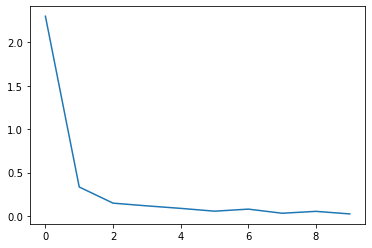

In [11]:
plt.plot(loss_arr)
plt.show()

## 테스트하기 

In [12]:
correct=0
total=0

with torch.no_grad():
  for image,label in test_loader:
    x=image.to(device)
    y_=label.to(device)
    output=model.forward(x)
     #https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
    _,output_index=torch.max(output,1)  #max함수는 max value와 max value의 index를 도출합니다. 두 번째 인자 1은 결과의 dimension을 의미합니다. 

    total+=label.size(0)

    correct += (output_index==y_).sum().float()

print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 98.64783477783203%


# 개선 CNN 모델

## 모델 정의하기

In [21]:
# with Batchnorm & Dropout

class NewCNN(nn.Module):
    def __init__(self):
        super(NewCNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),             # [batch_size,1,28,28] -> [batch_size,16,24,24]
            nn.BatchNorm2d(16),
            nn.ReLU(),                                                          # 필터의 개수(16개) 임의로 설정 
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),            # [batch_size,16,24,24] -> [batch_size,32,20,20]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                               # [batch_size,32,20,20] -> [batch_size,32,10,10]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),          # [batch_size,32,10,10] -> [batch_size,64,6,6]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                                # [batch_size,64,6,6] -> [batch_size,64,3,3]
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*3*3,100),                                              # [batch_size,64*3*3] -> [batch_size,100]
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100,10)                                                   # [batch_size,100] -> [batch_size,10]
        )       
        
    def forward(self,x):
        out = self.layer(x)                                                     # self.layer에 정의한 Sequential의 연산을 차례로 수행
        out = out.view(out.size(0),-1)                                           # view 함수를 이용해 텐서를 flatten 
                                                                                # ex) 2x3 텐서를 .view(1,-1) 해주면 1x6으로, view(3,-1)이면 3x2로
                                                                                # !전체 텐서의 크기가 batch_size로 나누어 떨어지지 않으면 오류!
        out = self.fc_layer(out)
        return out

## 손실함수와 최적화 함수 정의하기 

In [22]:
# gpu나 cpu를 device로 불러 device에서 학습이 진행되게끔 모델을 device에 올리기
# loss function과 optimizer도 정의해야 

device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')  

print(device)

model=NewCNN().to(device)

loss_func=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

cpu


In [23]:
from torchsummary import summary
summary(model,(1,28,28), batch_size=256)          # 파이토치는 입력을 (channel, width, height) 순으로

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 16, 24, 24]             416
       BatchNorm2d-2          [256, 16, 24, 24]              32
              ReLU-3          [256, 16, 24, 24]               0
            Conv2d-4          [256, 32, 20, 20]          12,832
       BatchNorm2d-5          [256, 32, 20, 20]              64
              ReLU-6          [256, 32, 20, 20]               0
         MaxPool2d-7          [256, 32, 10, 10]               0
            Conv2d-8            [256, 64, 6, 6]          51,264
       BatchNorm2d-9            [256, 64, 6, 6]             128
             ReLU-10            [256, 64, 6, 6]               0
        MaxPool2d-11            [256, 64, 3, 3]               0
           Linear-12                 [256, 100]          57,700
             ReLU-13                 [256, 100]               0
          Dropout-14                 [2

## 학습하기 

In [24]:
loss_arr=[]

for i in range(num_epoch):
  for j,[image,label] in enumerate(train_loader):
    x=image.to(device)            # 학습이미지
    y_=label.to(device)           # 정답을 device에 올리고.
    optimizer.zero_grad() 
    output=model.forward(x)       # 학습이미지를 모델에 돌린 결과
    loss=loss_func(output,y_)     # 결과와 정답을 loss function에 넣고 loss를 추출
    loss.backward()               # 추출된 loss를 통해 역전파
    optimizer.step()              # 역전파를 했다면 optimizer.step()를 통해 파라미터를 이동
    
    if j%1000==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3243, grad_fn=<NllLossBackward>)
tensor(0.1826, grad_fn=<NllLossBackward>)
tensor(0.1315, grad_fn=<NllLossBackward>)
tensor(0.0853, grad_fn=<NllLossBackward>)
tensor(0.0513, grad_fn=<NllLossBackward>)
tensor(0.0356, grad_fn=<NllLossBackward>)
tensor(0.0199, grad_fn=<NllLossBackward>)
tensor(0.0286, grad_fn=<NllLossBackward>)
tensor(0.0401, grad_fn=<NllLossBackward>)
tensor(0.0069, grad_fn=<NllLossBackward>)


## 손실 시각화 

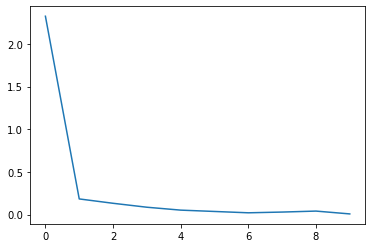

In [25]:
plt.plot(loss_arr)
plt.show()

## 테스트하기 

In [26]:
correct=0
total=0

with torch.no_grad():
  for image,label in test_loader:
    x=image.to(device)
    y_=label.to(device)
    output=model.forward(x)
     #https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
    _,output_index=torch.max(output,1)  #max함수는 max value와 max value의 index를 도출합니다. 두 번째 인자 1은 결과의 dimension을 의미합니다. 

    total+=label.size(0)

    correct += (output_index==y_).sum().float()

print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 98.72796630859375%


위처럼 동일 조건하에서 batchnormalization과 dropout을 추가해본 경우 다음과 같은 결과를 확인할 수 있다.
- train loss가 더 빨리 감소 = 학습이 빠르게 진행되는 것
- test acc가 0.1% 가량 오른 것